  Algoritmo de Redes neuronales combolucionales
  
  Instituto Politécnico Nacional
  
  ESCOM
  
  Alvarado Romero Luis Manuel
  
  Alejandre Dominguez Alan Jose   
  
  Materia: Machine learning
  
  Grupo: 6CV3


Importamos los plugins necesarios para realizar la practica

In [72]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn as skl
import matplotlib.pyplot as plt
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.applications.imagenet_utils import preprocess_input
from keras.optimizers import SGD
from sklearn.metrics import *

Montamos nuestro Google drive donde es que tenemos nuestro banco de imagenes 

In [73]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Verificamos la version de tensorflow que usaremos para nuestra practica

In [74]:
tf.__version__

'2.12.0'

Verificamos que estemos usando una GPU en colab para que esta se encarge del procesamiento de las imagenes


In [75]:
gpu_info=!nvidia-smi
gpu_info='\n'.join(gpu_info)
if gpu_info.find('failed')>=0:
  print('Not connected to a GPU')
else: 
  print(gpu_info)

tf.test.gpu_device_name()
print("Numero de GPU disponibles: ",len(tf.config.list_physical_devices("GPU")))

Sat Jun  3 05:55:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W /  70W |   1135MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Listamos las carpetas que encontramos en nuestro google drive

In [76]:
os.listdir('/content/drive/MyDrive/Practica6/')

['Train', 'Test']

Creamos las variables de hiperparametros para los conjuntos de entramiento y prueba


In [77]:
Train='/content/drive/MyDrive/Practica6/Train/'
Test='/content/drive/MyDrive/Practica6/Test/'
longitud,altura = 250,250
TBatch = 32
Nkernel = 7
Tkernel = (3,3)
Nepocas= 20
clase = 'binary'
optim=SGD(
  learning_rate=0.01,
  momentum=0.9,
  decay=0.01
)

Preparamos las imagenes del conjunto de entrenamiento y de prueba, donde les damos parametros al de entrenamiento para mejorar el entrenamiento de nuestra red como lo pueden ser el rescalamiento de las imagenes, que pueda inclinar un poco las imagenes, para mejorar el entrenamiento tambien damos una parte del conjunto de entrenamiento para el validacion como lo es el 20% de nuestro conjunto


In [78]:
Entrenamiento_datagen=ImageDataGenerator(rescale=1./255,horizontal_flip=True,shear_range=0.3,validation_split=0.2)
Prueba_datagen=ImageDataGenerator()

Entreanamiento_generator=Entrenamiento_datagen.flow_from_directory(
    Train,
    target_size=(altura,longitud),
    batch_size = TBatch,
    class_mode = clase,
    subset = 'training'    
)

Validacion_generator=Entrenamiento_datagen.flow_from_directory(
    Train,
    target_size=(altura,longitud),
    batch_size = TBatch,
    class_mode = clase,
    subset = 'validation'    
)

Prueba_generator=Prueba_datagen.flow_from_directory(
    Test,
    target_size=(altura,longitud),
    batch_size = TBatch,
    class_mode = clase,   
)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Creamos el modelo

In [79]:
modelo = Sequential()

#Creamos la primer capa
modelo.add(Conv2D(7,(3,3), strides=(2,2), activation='relu', input_shape=(altura, longitud, 3)))
modelo.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

#Creamos una segunda capa
modelo.add(Conv2D(7,(3,3), strides=(2,2), activation='relu', input_shape=(altura, longitud, 3)))
modelo.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

#Realizamos el aplanado
modelo.add(Flatten())
modelo.add(Dense(512, activation='relu'))
modelo.add(Dense(1, activation='sigmoid'))
modelo.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 124, 7)       196       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 61, 61, 7)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 7)         448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 7)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1372)              0         
                                                                 
 dense_4 (Dense)             (None, 512)              

Alimentamos nuestro modelo y lo entrnamos por 20 epocas usando nuestro conjunto de entreamiento y validacion


In [80]:

modelo.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
with tf.device('/device:GPU:0'):
  historial = modelo.fit(
      Entreanamiento_generator,
      steps_per_epoch=len(Entreanamiento_generator),
      epochs = Nepocas,
      validation_data=Validacion_generator,
      validation_steps=len(Validacion_generator)
  )

Epoch 1/20
200/200 [==============================] - 143s 712ms/step - loss: 0.6720 - accuracy: 0.5803 - val_loss: 0.6495 - val_accuracy: 0.6150
Epoch 2/20
200/200 [==============================] - 139s 698ms/step - loss: 0.6496 - accuracy: 0.6102 - val_loss: 0.6353 - val_accuracy: 0.6275
Epoch 3/20
200/200 [==============================] - 143s 717ms/step - loss: 0.6389 - accuracy: 0.6147 - val_loss: 0.6298 - val_accuracy: 0.6356
Epoch 4/20
200/200 [==============================] - 135s 677ms/step - loss: 0.6287 - accuracy: 0.6328 - val_loss: 0.6251 - val_accuracy: 0.6400
Epoch 5/20
200/200 [==============================] - 133s 664ms/step - loss: 0.6215 - accuracy: 0.6422 - val_loss: 0.6210 - val_accuracy: 0.6431
Epoch 6/20
200/200 [==============================] - 132s 661ms/step - loss: 0.6193 - accuracy: 0.6433 - val_loss: 0.6145 - val_accuracy: 0.6562
Epoch 7/20
200/200 [==============================] - 133s 666ms/step - loss: 0.6147 - accuracy: 0.6480 - val_loss: 0.6112 -

Creamos una metrica para ver si es que nuestra red neuronal si esta aprendiendo de una manera correcta y vemos si necesita entrenarse mas o no

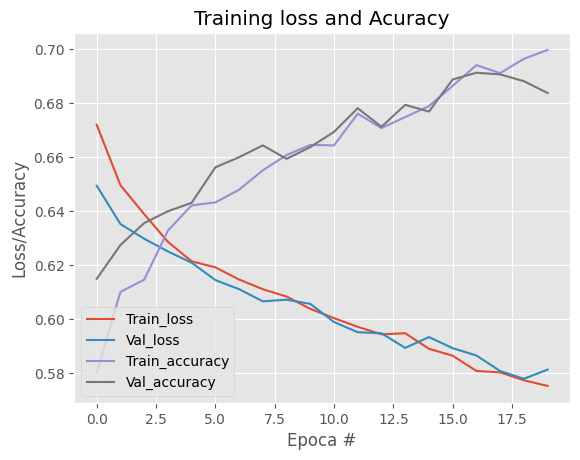

In [81]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, Nepocas), historial.history["loss"], label="Train_loss")
plt.plot(np.arange(0, Nepocas), historial.history["val_loss"], label="Val_loss")
plt.plot(np.arange(0, Nepocas), historial.history["accuracy"], label="Train_accuracy")
plt.plot(np.arange(0, Nepocas), historial.history["val_accuracy"], label="Val_accuracy")
plt.title("Training loss and Acuracy")
plt.xlabel("Epoca #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


Hacemos la prediccion de nuestro modelo con nuestros datos de prueba

In [82]:
with tf.device('/device:GPU:0'):
  Prediccion=modelo.predict(Prueba_generator)


63/63 [==============================] - 10s 150ms/step


Hacemos una variable donde convertimos las clases de nuestra prediccion para tener clases binarias

In [83]:
Prediccionfinal=np.where(Prediccion> 0.5,1,0)

Imprimos las clases predichas contra las clases reales


In [85]:
print("Clases reales:")
print(Prueba_generator.classes)
print("\nClases predichas:")
#Prediccionfinal=np.reshape(Prediccionfinal,(len(Prediccionfinal),1))
print(Prediccionfinal)
Acuracy=accuracy_score(Prueba_generator.classes,Prediccionfinal)
Recall=recall_score(Prueba_generator.classes,Prediccionfinal, average="macro")
Precision=precision_score(Prueba_generator.classes,Prediccionfinal, average="macro")
F1=f1_score(Prueba_generator.classes,Prediccionfinal, average="macro")
print("\nMetricas: \n")
print("Exactitud: ",Acuracy)
print("Sensibilidad: ",Recall)
print("Presicion: ",Precision)
print("F1: ",F1)

Clases reales:
[0 0 0 ... 1 1 1]

Clases predichas:
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]

Metricas: 

Exactitud:  0.502
Sensibilidad:  0.502
Presicion:  0.5082270670505964
F1:  0.3857728716351639
